In [ ]:
# Intersubject Correlation analysis of fMRI naturalistic data
# Correlate behavioral or clinical scores with with inter-individual brain response variability (measured as inter-subject correlation; ISC) during movie-viewing.
open https://naturalistic-data.org/content/Intersubject_Correlation.html

In [ ]:
# SOFTWARE

In [ ]:
# setup environment
qsub -I -N 'naturalistic' -l 'walltime=04:00:00,mem=30gb'
module load anaconda3/2021.05
source activate naturalistic

In [ ]:
jupyter notebook

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

# import nest_asyncio
# nest_asyncio.apply()
import datalad.api as dl

/home/mrstats/chrgon/.conda/envs/naturalistic/lib/python3.7/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.


In [2]:
cd /project/3022028.02

/project/3022028.02


In [3]:
ls

Sherlock/  tracula_w3_2021/


In [ ]:
# DATA

In [4]:
# define data directory
data_dir = '/project/3022028.02/Sherlock'

# Initialize dataset
ds = dl.Dataset(data_dir)

# Get Cropped & Denoised CSV Files
result = ds.get(glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*Average_ROI*csv')))

action summary:
  get (notneeded: 32)


In [ ]:
# ISC ANALYSIS

/home/mrstats/chrgon/.conda/envs/naturalistic/lib/python3.7/site-packages/nilearn/image/image.py:756: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  return klass(data, affine, header=header)


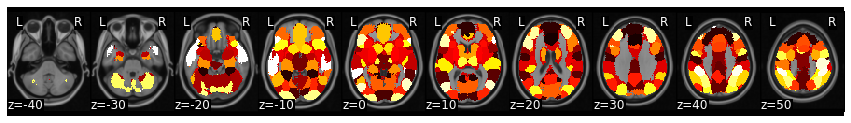

In [5]:
# download the k=50 whole brain meta-analytic parcellation of the neurosynth database
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')

# expand this mask into 50 separate binary masks
mask_x = expand_mask(mask)

mask.plot()

In [7]:
# load csv files for each participant
sub_list = [os.path.basename(x).split('_')[0] for x in glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', '*Part1*csv'))]
sub_list.sort()

In [8]:
# combine runs for each participant
sub_timeseries = {}
for sub in sub_list:
    part1 = pd.read_csv(os.path.join(data_dir, 'fmriprep', sub, 'func', f'{sub}_Part1_Average_ROI_n50.csv'))
    part2 = pd.read_csv(os.path.join(data_dir, 'fmriprep', sub, 'func', f'{sub}_Part2_Average_ROI_n50.csv'))
    sub_data = part1.append(part2)
    sub_data.reset_index(inplace=True, drop=True)
    sub_timeseries[sub] = sub_data

sub-01    sub-02    sub-03    sub-04    sub-05    sub-06    sub-07  \
0  3.362605 -1.967253 -0.243505  2.527032  5.166227 -0.678549  2.199253   
1  0.995695  1.730923  1.552836  1.068784  4.066954  0.117737  3.184899   
2  2.084567 -1.940155  1.914897  1.103097  2.168681  0.030628  2.036096   
3 -0.217049 -0.636084  1.501459 -0.701397  1.704406  0.042397  2.353035   
4 -2.628723  1.650023 -1.196258  0.079026  1.297944 -0.743593  1.188282   

         sub-08    sub-09    sub-10    sub-11        sub-12    sub-13  \
0 -1.646883e+00  0.421235  0.500547  0.361623  4.639737e+00  1.490442   
1  8.464993e-01 -0.118011  0.981400 -0.069505  2.522244e+00  1.145760   
2  1.782011e-01  0.984125  3.957482 -0.792416  1.326291e+00  0.472309   
3  1.088203e+00  1.650786  3.687806  3.839885  2.105321e-02 -2.885314   
4  3.375227e-13  1.515944 -0.709527  4.874887  2.279356e-13 -5.277045   

     sub-14    sub-15        sub-16  
0  1.806639  1.039467  3.483579e-13  
1 -0.582861 -0.420722 -1.237187e-13  
2 -3.066318  0.869296 -1.931528e-02  
3 -1.212683  1.213115 -1.460159e+00  
4  0.232831  1.914874  1.745742e+00

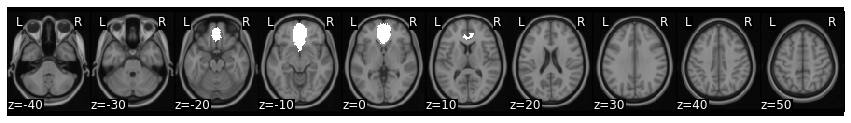

In [9]:
# pick a single ROI (e.g. vmPFC is roi=32)
roi = 32

# plot mask
mask_x[roi].plot()

# create a new pandas DataFrame that has average vmPFC activity for each participant
def get_subject_roi(data, roi):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub].iloc[:, roi]
    return pd.DataFrame(sub_rois)

sub_rois = get_subject_roi(sub_timeseries, roi)
sub_rois.head()

In [ ]:
# SUBJECT-WISE BOOTSTRAPPING because it's faster and more conservative

Text(0.5, 1.0, 'Bootstrapped Pairwise Similarity')

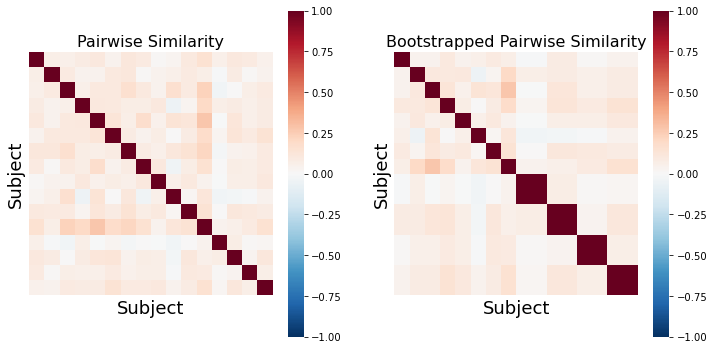

In [10]:
def bootstrap_subject_matrix(similarity_matrix, random_state=None):
    '''This function shuffles subjects within a similarity matrix based on recommendation by Chen et al., 2016'''
    
    random_state = check_random_state(random_state)
    n_sub = similarity_matrix.shape[0]
    bootstrap_subject = sorted(random_state.choice(np.arange(n_sub), size=n_sub, replace=True))
    return similarity_matrix[bootstrap_subject, :][:, bootstrap_subject]

similarity = 1 - pairwise_distances(pd.DataFrame(sub_rois).T, metric='correlation')

# plots
f,a = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
sns.heatmap(similarity, square=True, cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=a[0])
a[0].set_ylabel('Subject', fontsize=18)
a[0].set_xlabel('Subject', fontsize=18)
a[0].set_title('Pairwise Similarity', fontsize=16)

sns.heatmap(bootstrap_subject_matrix(similarity), square=True, cmap='RdBu_r', vmin=-1, vmax=1, xticklabels=False, yticklabels=False, ax=a[1])
a[1].set_ylabel('Subject', fontsize=18)
a[1].set_xlabel('Subject', fontsize=18)
a[1].set_title('Bootstrapped Pairwise Similarity', fontsize=16)

In [11]:
# statistics
stats_boot = isc(sub_rois, method='bootstrap', n_bootstraps=5000, return_bootstraps=True)

print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")

ISC: 0.074, p = 0.0002


In [ ]:
# WHOLE BRAIN ISC

In [12]:
# loop over each ROI and grab the column from each subject's dataframe
# run ISC on the combined subject?s ROI timeseries using the median method
# convert each correlation and p-value from each region back into a Brain_Data instanceand compute a hypothesis test using the subject-wise bootstrap method with 5000 samples
isc_r, isc_p = {}, {}
for roi in range(50):
    stats = isc(get_subject_roi(sub_timeseries, roi), n_bootstraps=5000, metric='median', method='bootstrap')
    isc_r[roi], isc_p[roi] = stats['isc'], stats['p']
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_r), mask_x), roi_to_brain(pd.Series(isc_p), mask_x)

/home/mrstats/chrgon/.conda/envs/naturalistic/lib/python3.7/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



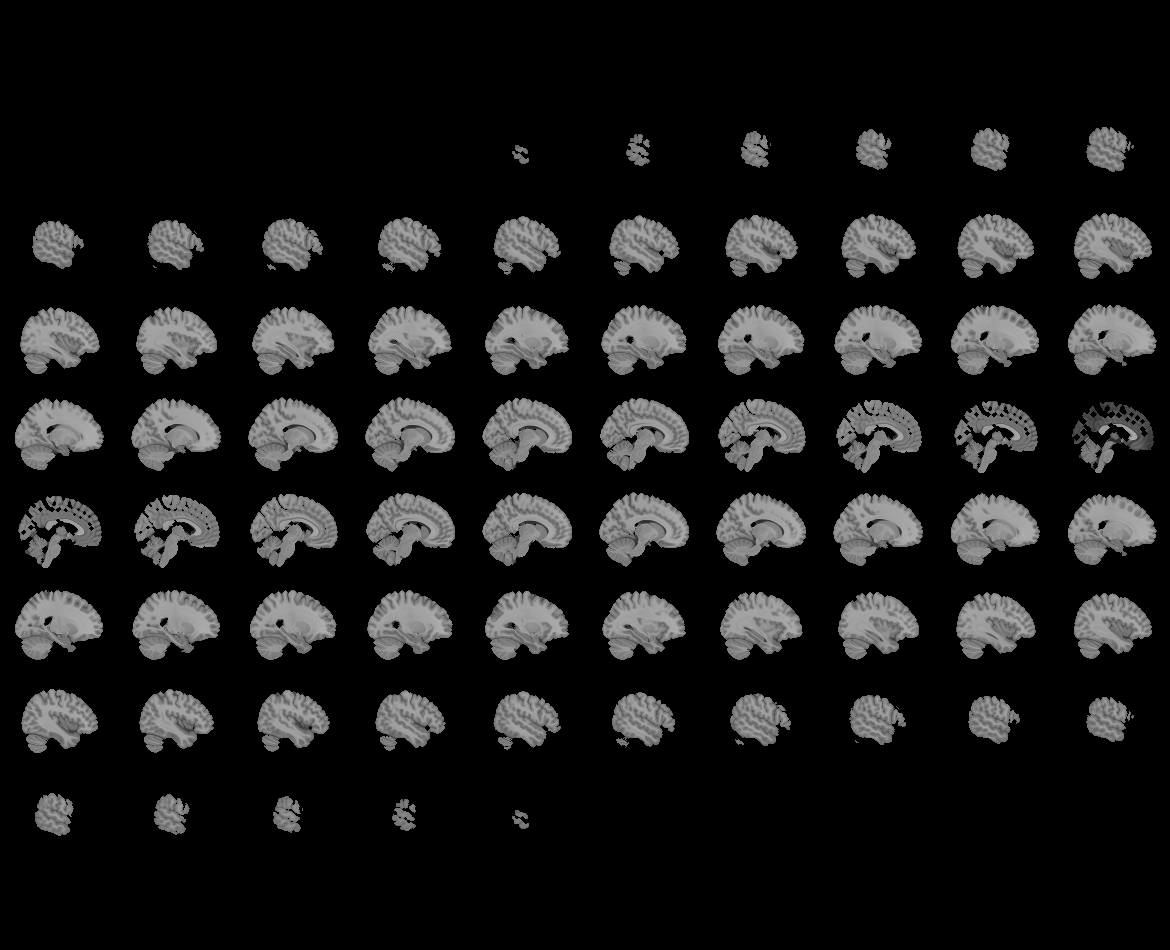
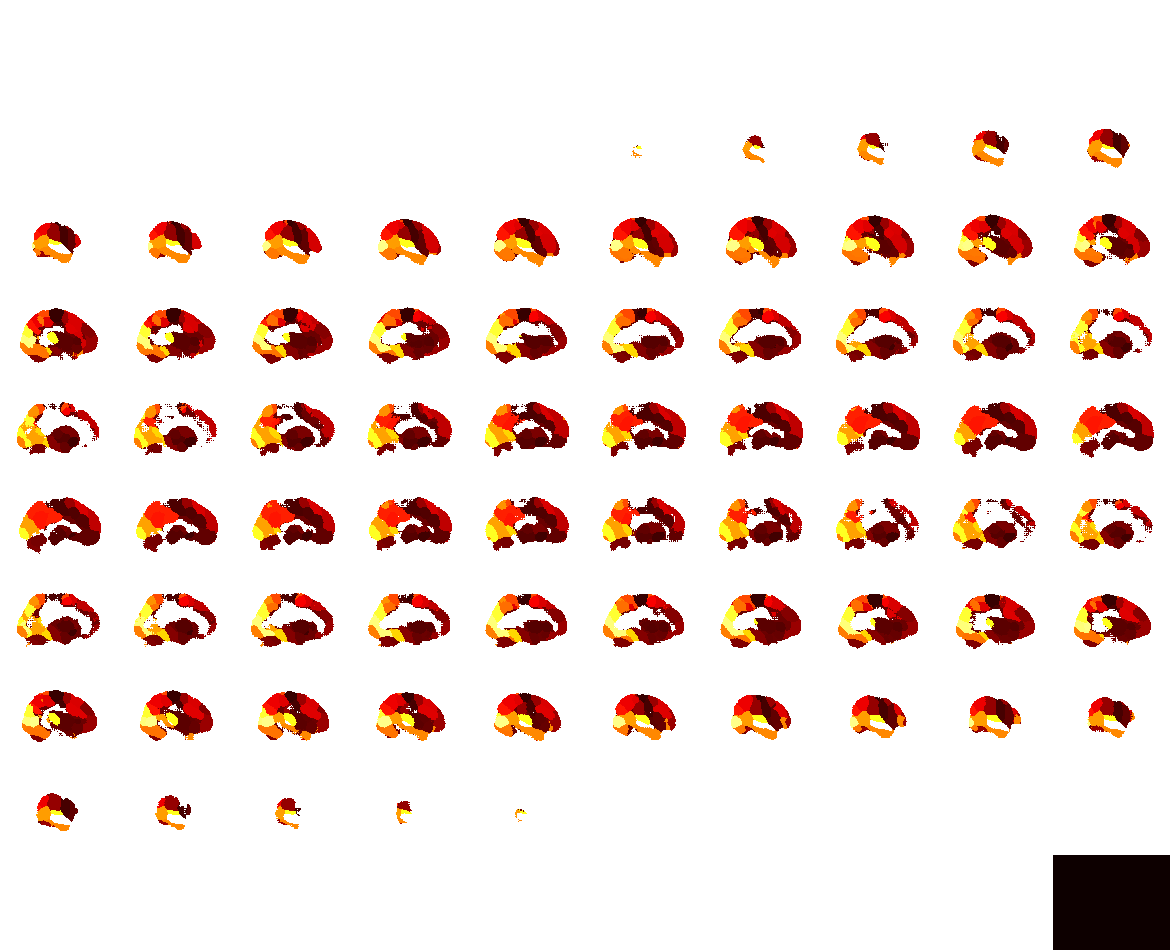

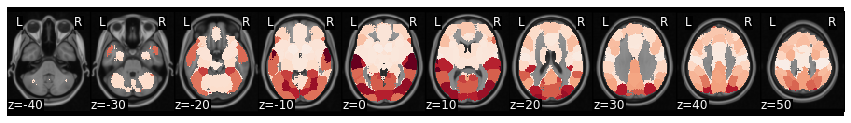

In [13]:
# plot the ISC values to visualize which regions had a higher overall ISC
isc_r_brain.plot(cmap='RdBu_r')
view_img(isc_r_brain.to_nifti())

In [18]:
# threshold with bonferroni
view_img_on_surf(threshold(isc_r_brain, isc_p_brain, thr=.001).to_nifti())

In [17]:
# or threshold with false discovery rate
view_img_on_surf(threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data)).to_nifti())